# Fairness regularizers

In this tutorial, we cover how to use OTT to build a differentiable regularizer to ensure an algorithm can take into account fairness constraints during training. This tutorial will focus on _group fairness_.

Group Fairness problems arise when a ML system produces different distributions of outcomes for different sub-populations or groups. The attributes defining the groups are called the _protected attributes_, and can typically be the gender, the race, the age, etc.

For instance, a face recognition system may have better precision or recall on young people than on old people, or a classifier for loan approval may favor men over women, reproducing biases. In the first case, it would be preferable that the distribution of errors made by the classifier be similar across groups, focusing on the _equalized odds_ metric, while in the second case it would be preferable that the distributions of predictions match, focusing instead on the _demographic parity_ metric.

Some fairness methods focus on manipulating the dataset, some others try to come up with different criteria or thresholds for the different groups. In our case we leverage the ability of optimal transport to deal with distributions and directly use the Wasserstein distance between the per-group distributions as a loss.


## Adult dataset

We apply our differentiable fairness regularizer on a common benchmark dataset, the [adult dataset](https://archive.ics.uci.edu/ml/datasets/adult): a binary classification problem that aims at predicting whether a given individual earns more or less than $50k a year, based on features such as the age, the gender, the education level, the country of birth, the workclass, etc. The considered protected attribute is the gender. There are therefore two groups.

Training a multi-layer perceptron (MLP) out of the box by minimizing the binary cross-entropy on the training data leads systematically predict more often that men, rather than women, earn more than $50k. The following figure is key to understand the fairness issue: it represents the quantiles of the predictions for men and for women for a trained classifier which accuracy is about 80%. While being overall quite good in terms of classification, it is doing poorly in terms of fairness since accuracy might be obtained at giving more importance to those several datapoints that were men. The goal of group fairness is to close the gap between those two curves.


In [1]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main

Text(0, 0.5, 'Prediction')

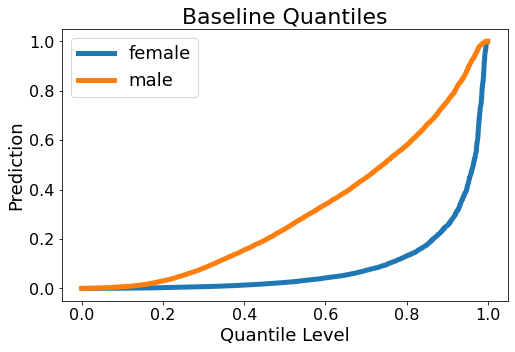

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_quantiles(logits, groups, ax)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.set_title(f"Baseline Quantiles", fontsize=22)
ax.set_xlabel("Quantile Level", fontsize=18)
ax.set_ylabel("Prediction", fontsize=18)

To obtain these curves, we _sort_ the predictions made by the classifier from the smallest to the biggest for each group and put them on a $[0, 1]$ scale on the x-axis. The value corresponding to $x=0.5$ is the median of the distribution. Similarly for each quantile level in $[0,1]$ we obtain the corresponding quantile of the distribution.

In this example we observe that the median prediction for women is about 5% while the median prediction for men is about 25%. If we were to set to 0.25 the threshold to consider a prediction positive, we would keep half of the men, but would reject about 90% of the women.

## Quantiles and Wasserstein distance.

The gap between the two quantile functions is corresponds to
 the _Wasserstein distance_ between the two distributions. Closing the gap between the two curves is equivalent to minimizing the Wasserstein distance between the two distributions.

Note that in practice, we approximate the gap by the average of the distances between corresponding quantile levels. For this we need to interpolate the values over the union of the supports of the two discrete quantile maps.

Let's do this on an example. We sample some points uniformly at random, and assign randomly groups to them and plot the quantiles functions.

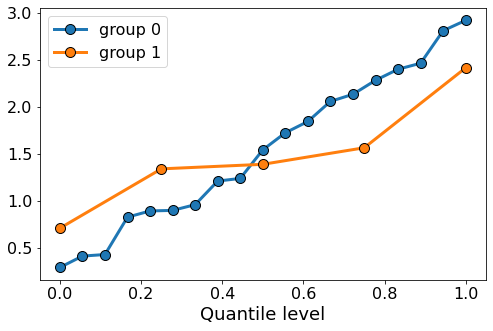

In [ ]:
N = 24

rng = jax.random.PRNGKey(1)
rng, *rngs = jax.random.split(rng, 3)
y_pred = 3 * jax.random.uniform(rngs[0], (N,))
groups = jax.random.uniform(rngs[1], (N,)) < 0.25

support_0 = jnp.linspace(0, 1, N - jnp.sum(groups))
support_1 = jnp.linspace(0, 1, jnp.sum(groups))
quantiles_0 = jnp.sort(y_pred[jnp.logical_not(groups)])
quantiles_1 = jnp.sort(y_pred[groups])

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.plot(
    support_0,
    quantiles_0,
    lw=3,
    marker="o",
    markersize=10,
    label="group 0",
    markeredgecolor="k",
)
ax.plot(
    support_1,
    quantiles_1,
    lw=3,
    marker="o",
    markersize=10,
    label="group 1",
    markeredgecolor="k",
)
ax.set_xlabel("Quantile level", fontsize=18)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.legend(fontsize=16)

We can see on this figure that the support of the two quantile function is different, since the number of points in the two groups is different. In order to compute the gap between the two curves, we first interpolate the two curves on the union of the supports. The Wasserstein distance corresponds to the gap between the two quantile functions. Here we show two interpolations schemes that make it easy to estimate the Wasserstein distance between two 1D measures.

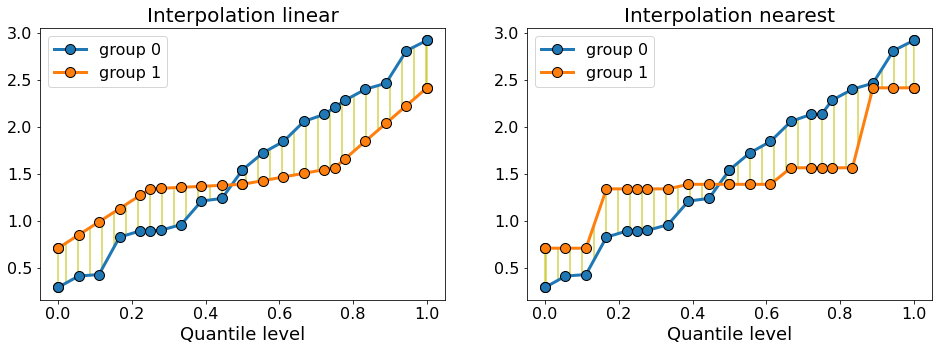

In [ ]:
import scipy

kinds = ["linear", "nearest"]
fig, axes = plt.subplots(1, len(kinds), figsize=(8 * len(kinds), 5))

for ax, kind in zip(axes, kinds):
    q0 = scipy.interpolate.interp1d(support_0, quantiles_0, kind=kind)
    q1 = scipy.interpolate.interp1d(support_1, quantiles_1, kind=kind)
    support_01 = jnp.sort(jnp.concatenate([support_0, support_1]))

    ax.plot(
        support_01,
        q0(support_01),
        label="group 0",
        lw=3,
        marker="o",
        markersize=10,
        markeredgecolor="k",
    )
    ax.plot(
        support_01,
        q1(support_01),
        label="group 1",
        lw=3,
        marker="o",
        markersize=10,
        markeredgecolor="k",
    )
    ax.fill_between(
        support_01, q0(support_01), q1(support_01), color="y", hatch="|", fc="w"
    )
    ax.set_xlabel("Quantile level", fontsize=18)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.legend(fontsize=16)
    ax.set_title(f"Interpolation {kind}", fontsize=20)

## Soft Wasserstein

Computing the Wasserstein distance involves complex operations such as sorting and interpolating. Fortunately, regularized optimal transport and its implementation with OTT provides accelerator-friendly differentiable approaches to sort according to a group (setting the weights of the outsiders to zero) while mapping onto a common support (sorting onto a fixed target of the same size, no matter what the group is).

Here is an example of how to use OTT to obtain a sorted vector of a fixed size for each group. Note how simple this function is.

In [ ]:
import functools


@functools.partial(jax.jit, static_argnums=(2,))
def sort_group(inputs: jnp.ndarray, group: jnp.ndarray, target_size: int = 16):
    a = group / jnp.sum(group)
    b = jnp.ones(target_size) / target_size
    ot = ott.tools.soft_sort.transport_for_sort(
        inputs, a, b, dict(epsilon=1e-3)
    )
    return 1.0 / b * ot.apply(inputs, axis=0)

It is noteworthy to see that the obtained interpolation corresponds to a smooth version of the 'nearest' interpolation.

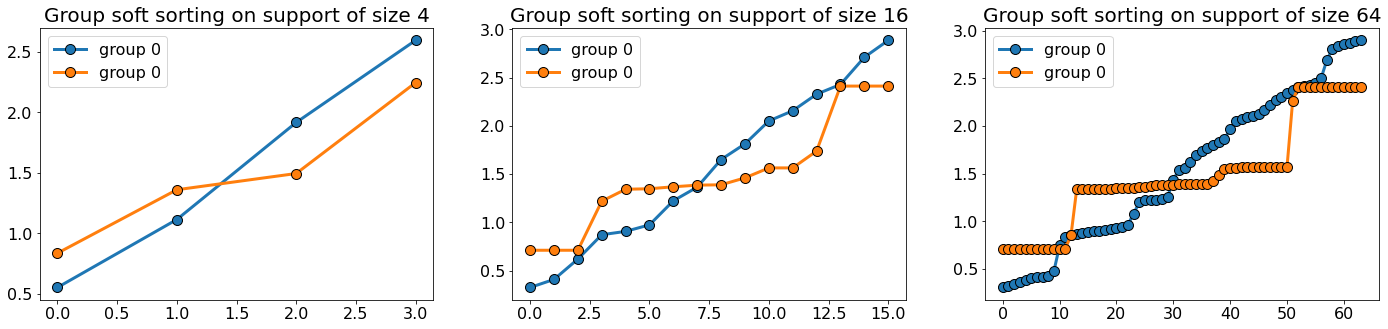

In [ ]:
target_sizes = [4, 16, 64]
_, axes = plt.subplots(1, len(target_sizes), figsize=(len(target_sizes * 8), 5))
for ax, target_size in zip(axes, target_sizes):
    ax.plot(
        sort_group(y_pred, jnp.logical_not(groups), target_size),
        lw=3,
        marker="o",
        markersize=10,
        markeredgecolor="k",
        label="group 0",
    )
    ax.plot(
        sort_group(y_pred, groups, target_size),
        lw=3,
        marker="o",
        markersize=10,
        markeredgecolor="k",
        label="group 0",
    )
    ax.legend(fontsize=16)
    ax.tick_params(axis="both", which="major", labelsize=16)
    ax.set_title(
        f"Group soft sorting on support of size {target_size}", fontsize=20
    )

## Training a network

In order to train our classifier with a fairness regularizer, we first turn the categorical features $x$ of the adult dataset into dense ones (using 16 dimensions) and pass the obtained vector to an MLP $f_\theta$ with 2 hidden layers of 64 neurons.

We optimize a loss which is the sum of the binary crossentropy and the Wasserstein distance between the distributions of predictions for the two classes. Since we want to work with minibatches and we do not want to change the common optimization scheme, we decide to use rather big batches of size $512$, in order to ensure that we have enough predictions across groups in a batch for the Wasserstein distance between them to make sense.

We scale the Wasserstein distance by a factor $\lambda$ to control the balance between the fitness term (binary crossentropy) and the fairness regularization term (Wasserstein distance).

We run the training procedure for 100 epochs with the Adam optimizer with learning rate $10^{-4}$, an entropic regularization factor $\epsilon=10^{-3}$ and a common interpolation support of size $12$.

We compare the results for $\lambda \in \{1, 10, 100, 1000\}$ in terms of demographic parity as well as accuracy.

## Loss and Accuracy

Let's first compare the performance of all those classifiers. 

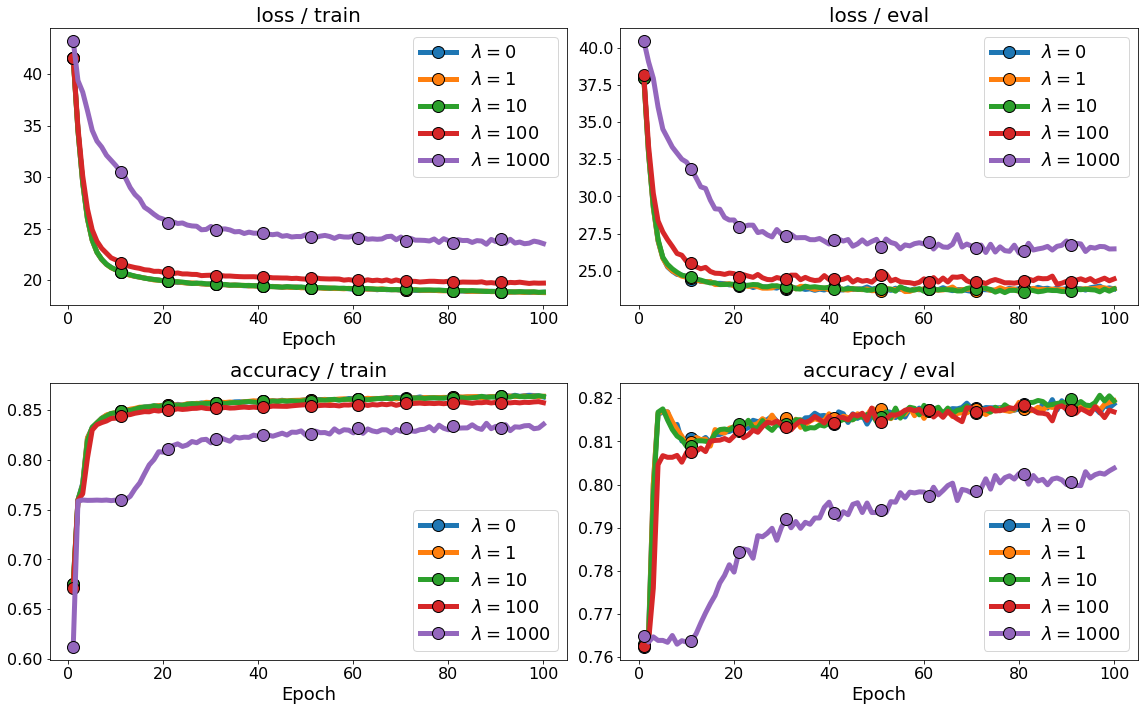

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for weight, curves in result.items():
    for ax_row, metric in zip(axes, ["loss", "accuracy"]):
        for ax, phase in zip(ax_row, ["train", "eval"]):
            arr = np.array(curves[f"{phase}_{metric}"])
            ax.plot(
                arr[:, 0],
                arr[:, 1],
                label=rf"$\lambda={weight:.0f}$",
                lw=5,
                marker="o",
                markersize=12,
                markeredgecolor="k",
                markevery=10,
            )
            ax.set_title(f"{metric} / {phase}", fontsize=20)
            ax.legend(fontsize=18)
            ax.set_xlabel("Epoch", fontsize=18)
            ax.tick_params(axis="both", which="major", labelsize=16)
plt.tight_layout()

We can see that when we increase the fairness regularization factor $\lambda$, the training accuracy slightly decreases but it does not impact too much the eval accuracy. The fairness regularizer is a rather good regularizer. For $\lambda = 1000$ the training metrics are a bit more degraded as well as the eval ones, but we also note that after 100 epochs this classifier has not converged yet, so we could also imagine that it would catch up in terms of eval metrics.

## Demographic Parity

Now that we have seen the effect of the fairness regularizer on the classification performance, we focus on the applicability of this regularizer on the distributions of predictions for the two groups.

For this, we compute all the predictions, sort them and plot the quantile functions. The smaller the area between them, the more fair the classifier is.

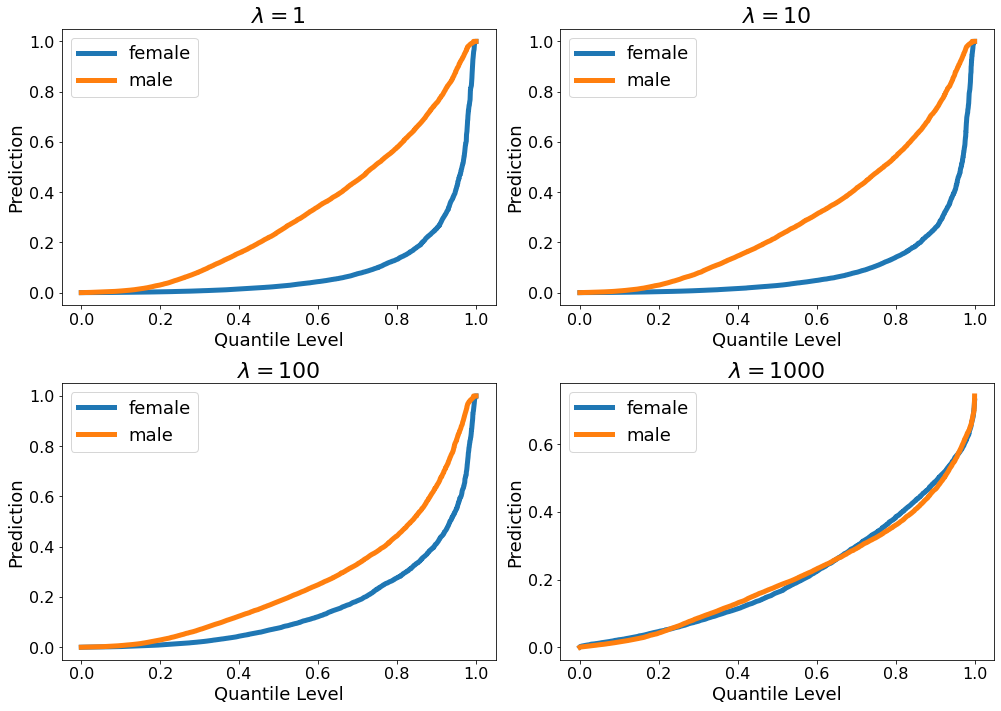

In [ ]:
num_rows = 2
num_cols = len(weights[1:]) // 2
fig, axes = plt.subplots(
    num_rows, num_cols, figsize=(7 * num_cols, 5 * num_rows)
)
for ax, w in zip(axes.ravel(), weights[1:]):
    logits, groups = get_predictions(ds_test, config, states[w])
    plot_quantiles(logits, groups, ax)
    ax.set_title(rf"$\lambda = {w:.0f}$", fontsize=22)
    ax.set_ylabel("Prediction", fontsize=18)
plt.tight_layout()

We clearly see that as we increase the fairness factor, the network finds ways to enforce the demographic parity (it is totally fair for $\lambda = 1000$) with no or little decrease of classification performance (a drop of about 1% in accuracy).

Unlike many fairness methods, the OT-based fairness regularizer does not modify the training procedure and makes it possible to train end-to-end an ML system by enforcing a meaningful criterion: the Wasserstein distance between distributions of predictions.